In [1]:
#%% -------- 1. Imports & Configuration --------
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, 
                             confusion_matrix, classification_report)
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.models import Model

# Configuration
TARGET_SIZE = (224, 224)  # ResNet input size
DATA_PATHS = {
    'train': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train",
    'valid': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val",
    'test': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"
}

In [2]:
#%% -------- 2. Metaheuristic Optimizers --------
class PSOFeatureSelector:
    def __init__(self, n_particles=20, iterations=50):
        self.n_particles = n_particles
        self.iterations = iterations
        self.best_features = None

    def optimize(self, X, y):
        n_features = X.shape[1]
        particles = np.random.rand(self.n_particles, n_features)
        velocities = np.zeros_like(particles)
        pbest = particles.copy()
        pbest_scores = np.zeros(self.n_particles)
        gbest, gbest_score = None, 0

        for i in range(self.n_particles):
            score = self._fitness(X, y, particles[i])
            pbest_scores[i] = score
            if score > gbest_score:
                gbest_score, gbest = score, particles[i].copy()

        for _ in range(self.iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.rand(2)
                velocities[i] += 2*r1*(pbest[i] - particles[i]) + \
                                2*r2*(gbest - particles[i])
                particles[i] = 1/(1+np.exp(-velocities[i]))
                score = self._fitness(X, y, particles[i])
                if score > pbest_scores[i]:
                    pbest_scores[i] = score
                    pbest[i] = particles[i].copy()
                    if score > gbest_score:
                        gbest_score, gbest = score, particles[i].copy()

        self.best_features = gbest > 0.5
        return self.best_features

    def _fitness(self, X, y, particle):
        mask = particle > 0.5
        if sum(mask) == 0: return 0
        return cross_val_score(LogisticRegression(), X[:,mask], y, 
                             cv=3, scoring='accuracy').mean()

class GWOFeatureSelector:
    def __init__(self, n_wolves=20, iterations=50):
        self.n_wolves = n_wolves
        self.iterations = iterations
        self.best_features = None

    def optimize(self, X, y):
        n_features = X.shape[1]
        wolves = np.random.rand(self.n_wolves, n_features)
        alpha = beta = delta = None
        alpha_score = beta_score = delta_score = -np.inf

        for it in range(self.iterations):
            scores = [self._fitness(X, y, wolf) for wolf in wolves]
            for i, score in enumerate(scores):
                if score > alpha_score:
                    alpha_score, beta_score, delta_score = score, alpha_score, beta_score
                    alpha, beta, delta = wolves[i].copy(), alpha, beta
                elif score > beta_score:
                    beta_score, delta_score = score, beta_score
                    beta, delta = wolves[i].copy(), beta
                elif score > delta_score:
                    delta_score = score
                    delta = wolves[i].copy()

            a = 2 - 2*(it/self.iterations)
            for i in range(self.n_wolves):
                A1, A2, A3 = a*(2*np.random.rand(3)-1)
                D_alpha = np.abs(A1*alpha - wolves[i])
                D_beta = np.abs(A2*beta - wolves[i])
                D_delta = np.abs(A3*delta - wolves[i])
                wolves[i] = (alpha - A1*D_alpha + 
                            beta - A2*D_beta + 
                            delta - A3*D_delta)/3

        self.best_features = alpha > 0.5
        return self.best_features

    def _fitness(self, X, y, wolf):
        mask = wolf > 0.5
        if sum(mask) == 0: return 0
        return cross_val_score(LogisticRegression(), X[:,mask], y,
                             cv=3, scoring='accuracy').mean()

In [3]:
#%% -------- 3. ResNet Feature Extractor --------
class ResNetFeatureExtractor:
    def __init__(self):
        self.base_model = applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(*TARGET_SIZE, 3),
            pooling='avg'  # Global average pooling
        )
        self.feature_model = self._build_feature_extractor()
        
    def _build_feature_extractor(self):
        return Model(
            inputs=self.base_model.input,
            outputs=self.base_model.output
        )
    
    def extract_features(self, images):
        return self.feature_model.predict(applications.resnet.preprocess_input(images))
    
    def fine_tune(self, train_data, val_data, epochs=20):
        # Freeze base layers
        self.base_model.trainable = False
        
        # Create classification model
        inputs = layers.Input(shape=(*TARGET_SIZE, 3))
        x = self.base_model(inputs, training=False)
        x = layers.Dense(256, activation='relu')(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs, outputs)
        model.compile(
            optimizer=optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        model.fit(
            train_data,
            validation_data=val_data,
            epochs=epochs,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
        )
        return model

In [4]:
#%% -------- 4. Data Loading & Processing --------
def load_resnet_images(directory):
    images, labels = [], []
    for label in ['female', 'male']:
        path = os.path.join(directory, label)
        for file in os.listdir(path):
            img = cv2.imread(os.path.join(path, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, TARGET_SIZE)
            images.append(img)
            labels.append(1 if label == 'male' else 0)
    return np.array(images), np.array(labels).reshape(-1, 1)

# Load datasets
train_images, train_labels = load_resnet_images(DATA_PATHS['train'])
valid_images, valid_labels = load_resnet_images(DATA_PATHS['valid'])
test_images, test_labels = load_resnet_images(DATA_PATHS['test'])

# Convert to float32 and preprocess
train_images = applications.resnet.preprocess_input(train_images.astype('float32'))
valid_images = applications.resnet.preprocess_input(valid_images.astype('float32'))
test_images = applications.resnet.preprocess_input(test_images.astype('float32'))

In [5]:
#%% -------- 5. Hybrid Training Pipeline --------
# Initialize ResNet system
resnet_system = ResNetFeatureExtractor()

# 1. Fine-tune ResNet
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).batch(32)

classification_model = resnet_system.fine_tune(
    train_dataset,
    val_dataset,
    epochs=20
)

# 2. Extract features
train_features = resnet_system.extract_features(train_images)
valid_features = resnet_system.extract_features(valid_images)
test_features = resnet_system.extract_features(test_images)

# 3. Prepare feature matrix
X_full = np.vstack([train_features, valid_features])
y_full = np.concatenate([train_labels, valid_labels])
X_full, y_full = SMOTE().fit_resample(X_full, y_full)

# 4. Feature Selection
pso = PSOFeatureSelector(n_particles=30)
pso_mask = pso.optimize(X_full, y_full)
X_pso = X_full[:, pso_mask]

gwo = GWOFeatureSelector(n_wolves=30)
gwo_mask = gwo.optimize(X_pso, y_full)
X_selected = X_pso[:, gwo_mask]

# 5. Train final classifier
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', 
                              solver='saga', max_iter=2000))
])
classifier.fit(X_selected, y_full)

# 6. Prepare test features
X_test_pso = test_features[:, pso.best_features]
X_test_selected = X_test_pso[:, gwo.best_features]

Epoch 1/20
22/22 [==============================] - 53s 2s/step - loss: 0.5202 - accuracy: 0.7449 - val_loss: 0.2922 - val_accuracy: 0.9133
Epoch 2/20
22/22 [==============================] - 50s 2s/step - loss: 0.2637 - accuracy: 0.9184 - val_loss: 0.2076 - val_accuracy: 0.9286
Epoch 3/20
22/22 [==============================] - 49s 2s/step - loss: 0.1988 - accuracy: 0.9359 - val_loss: 0.1814 - val_accuracy: 0.9388
Epoch 4/20
22/22 [==============================] - 49s 2s/step - loss: 0.1692 - accuracy: 0.9475 - val_loss: 0.1688 - val_accuracy: 0.9490
Epoch 5/20
22/22 [==============================] - 51s 2s/step - loss: 0.1486 - accuracy: 0.9504 - val_loss: 0.1677 - val_accuracy: 0.9439
Epoch 6/20
22/22 [==============================] - 49s 2s/step - loss: 0.1382 - accuracy: 0.9592 - val_loss: 0.1565 - val_accuracy: 0.9439
Epoch 7/20
22/22 [==============================] - 50s 2s/step - loss: 0.1220 - accuracy: 0.9679 - val_loss: 0.1548 - val_accuracy: 0.9439
Epoch 8/20
22/22 [==

Test Accuracy: 93.81%
AUC-ROC: 98.43%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.92      0.96      0.94        48

    accuracy                           0.94        97
   macro avg       0.94      0.94      0.94        97
weighted avg       0.94      0.94      0.94        97



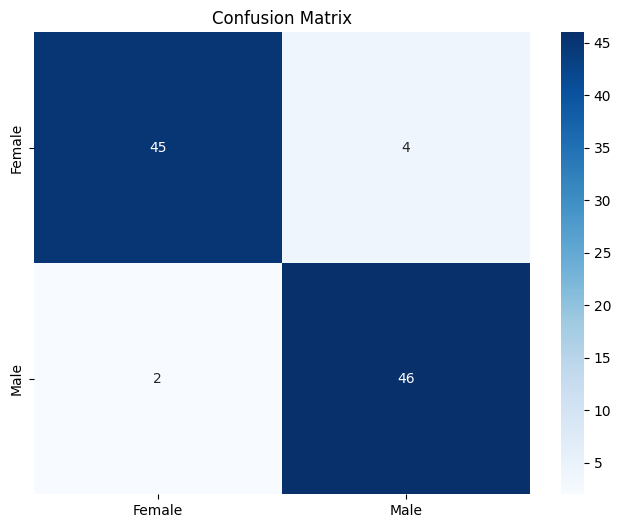

In [6]:
import seaborn as sns

#%% -------- 6. Evaluation --------
test_pred = classifier.predict(X_test_selected)
test_proba = classifier.predict_proba(X_test_selected)[:, 1]

print(f"Test Accuracy: {accuracy_score(test_labels, test_pred):.2%}")
print(f"AUC-ROC: {roc_auc_score(test_labels, test_proba):.2%}")
print("\nClassification Report:")
print(classification_report(test_labels, test_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_labels, test_pred), 
           annot=True, fmt='d', cmap='Blues',
           xticklabels=['Female', 'Male'], 
           yticklabels=['Female', 'Male'])
plt.title("Confusion Matrix")
plt.show()

In [7]:
#%% -------- 7. Model Saving --------
save_data = {
    'resnet_model': resnet_system.feature_model,
    'pso_mask': pso.best_features,
    'gwo_mask': gwo.best_features,
    'classifier': classifier,
    'label_encoder': LabelEncoder().fit(['female', 'male'])
}
joblib.dump(save_data, 'resnet_hybrid_classifier.pkl')

['resnet_hybrid_classifier.pkl']

In [8]:
#%% -------- 8. Inference Function --------
def predict_gender(image_path):
    # Load components
    model_data = joblib.load('resnet_hybrid_classifier.pkl')
    resnet = model_data['resnet_model']
    pso_mask = model_data['pso_mask']
    gwo_mask = model_data['gwo_mask']
    classifier = model_data['classifier']
    le = model_data['label_encoder']
    
    # Process image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, TARGET_SIZE)
    img = applications.resnet.preprocess_input(img.astype('float32'))
    
    # Extract features
    resnet_features = resnet.predict(np.expand_dims(img, axis=0))
    
    # Select features
    features_pso = resnet_features[:, pso_mask]
    features_selected = features_pso[:, gwo_mask]
    
    # Predict
    proba = classifier.predict_proba(features_selected)[0]
    return 'Male' if proba[1] > 0.5 else 'Female', max(proba)

# Example usage
test_image = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\male\\male.441.JPG"
pred, confidence = predict_gender(test_image)
print(f"Prediction: {pred} with {confidence:.2%} confidence")

1/1 [==============================] - 1s 855ms/step
Prediction: Female with 100.00% confidence
